In [ ]:
!pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=38f291b59b2502b756f475ae5cc3b7cab3530f4cf40949acc3d840bb20676fe6
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
#Create a Spark Session
from pyspark.sql import SparkSession

spark= SparkSession.builder.appName("description").getOrCreate()


In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

# Schema defined as infering  it directly with spark alters the content in my case.
schema = StructType([
    StructField("book_id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("description", StringType(), True)
])


file_path = "/content/drive/MyDrive/Data Mining/description.csv"

# Allows for multiple lines in a given row
df_description = spark.read.option("multiline", "true").option("escape", "\"").csv(file_path, schema=schema, header=True)


# Show all rows
df_description.show(df_description.count())



+-------+--------------------+--------------------+
|book_id|                name|         description|
+-------+--------------------+--------------------+
|   4833|    The Glass Castle|A tender, moving ...|
|    590|Night (The Night ...|Born into a Jewis...|
|   4264|Angela's Ashes (F...|Imbued on every p...|
|   3361|    Eat, Pray, Love |A celebrated writ...|
|   4535|Into Thin Air: A ...|A bank of clouds ...|
|    518|Tuesdays with Morrie|Maybe it was a gr...|
|   3781|Running with Scis...|The true story of...|
|   3190|       Into the Wild|In April 1992 a y...|
|   3147|I Know Why the Ca...|Sent by their mot...|
|    225|A Child Called "I...|This book chronic...|
|   3035|Chickens, Mules a...|Perhaps if Joe an...|
|     99|Persepolis: The S...|Wise, funny, and ...|
|   3594|The Autobiography...|Through a life of...|
|   4971|The Hiding Place:...|At one time Corri...|
|   1381|All Creatures Gre...|Delve into the ma...|
|   3099|         Confessions|Augustine's Confe...|
|     45|Me 

Drop null values

In [ ]:
# Drop NULL values from the DataFrame
df_description= df_description.na.drop()

**Resulting Rows**

After dropping all the NULL values, I am left with 122 ROWS of DATA.

In [ ]:
df_description.count()

122

In [ ]:
df_description.show(df_description.count())

+-------+--------------------+--------------------+
|book_id|                name|         description|
+-------+--------------------+--------------------+
|   4833|    The Glass Castle|A tender, moving ...|
|    590|Night (The Night ...|Born into a Jewis...|
|   4264|Angela's Ashes (F...|Imbued on every p...|
|   3361|    Eat, Pray, Love |A celebrated writ...|
|   4535|Into Thin Air: A ...|A bank of clouds ...|
|    518|Tuesdays with Morrie|Maybe it was a gr...|
|   3781|Running with Scis...|The true story of...|
|   3190|       Into the Wild|In April 1992 a y...|
|   3147|I Know Why the Ca...|Sent by their mot...|
|    225|A Child Called "I...|This book chronic...|
|   3035|Chickens, Mules a...|Perhaps if Joe an...|
|     99|Persepolis: The S...|Wise, funny, and ...|
|   3594|The Autobiography...|Through a life of...|
|   4971|The Hiding Place:...|At one time Corri...|
|   1381|All Creatures Gre...|Delve into the ma...|
|   3099|         Confessions|Augustine's Confe...|
|     45|Me 

**Tokenize Data**

In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
import seaborn as sns
from matplotlib import pyplot as plt



# Tokenize the text
tokenizer = Tokenizer(inputCol="description", outputCol="words")

words = tokenizer.transform(df_description)

In [ ]:
# Show sample Tokenized words
words.select("book_id", "words").show(10, truncate=False)


+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Remove stopwords**

In [ ]:
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="words")


**Lemmatize**

In [ ]:
# from pyspark.sql.functions import col, udf
# from pyspark.sql.types import ArrayType, StringType
# import spacy


# nlp = spacy.load("en_core_web_sm")

# def lemmatize_tokens(tokens):
#     return [token.lemma_ for token in nlp(" ".join(tokens))]

# lemmatize_udf = udf(lemmatize_tokens, ArrayType(StringType()))
# words = words.withColumn("words", lemmatize_udf(col("words")))


**Vectorize Tokenized Data**


In Spark ML, TF-IDF is separate into two parts: TF (+hashing) and IDF. TF: HashingTF is a Transformer which takes sets of terms and converts those sets into fixed-length feature vectors.

In [ ]:
# Apply TF-IDF
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
idf = IDF(inputCol="rawFeatures", outputCol="features")

tf_idf_model = idf.fit(hashingTF.transform(words))
vectorized_data = tf_idf_model.transform(hashingTF.transform(words))


In [ ]:
vectorized_data.count()

122

**Training Data**

Cleaned Data goes upto 122 rows.
For training, I picked upto 121 rows to represent the first 121 books as the book_id is not in any order.

In [ ]:
train_data = vectorized_data.limit(121)


In [ ]:
train_data.count()

121

**K-Means Algorithm - 10 clusters**

Partition based clustering was used as we had provided with the number of clusters required in the question.
KMeans method was used as that's the only method I was familiar with.

In [ ]:
#
kmeans = KMeans(k=10, seed=1, featuresCol="features", predictionCol="cluster", maxIter=50)
model = kmeans.fit(train_data)

In [ ]:
# Top 5 Terms in each cluster
terms = []
for i in range(3):
    cluster_center = model.clusterCenters()[i]
    cluster_terms = [f"term_{j}" for j in sorted(range(len(cluster_center)), key=lambda x: cluster_center[x], reverse=True)]

    terms.append(cluster_terms)
    print(f"Cluster {i + 1} Terms : {cluster_terms}")


Cluster 1 Terms : ['term_4', 'term_0', 'term_2', 'term_14', 'term_17', 'term_19', 'term_7', 'term_6', 'term_13', 'term_18', 'term_1', 'term_5', 'term_10', 'term_8', 'term_3', 'term_9', 'term_16', 'term_15', 'term_12', 'term_11']
Cluster 2 Terms : ['term_18', 'term_0', 'term_4', 'term_2', 'term_14', 'term_1', 'term_12', 'term_5', 'term_17', 'term_6', 'term_9', 'term_19', 'term_13', 'term_16', 'term_10', 'term_8', 'term_3', 'term_7', 'term_15', 'term_11']
Cluster 3 Terms : ['term_19', 'term_1', 'term_12', 'term_14', 'term_9', 'term_0', 'term_2', 'term_18', 'term_4', 'term_5', 'term_17', 'term_16', 'term_13', 'term_10', 'term_7', 'term_6', 'term_3', 'term_8', 'term_15', 'term_11']


**Please Note**

The question asks for the 136th book. However, for my case, after dropping all the NULL values I have 122 books left from original 144 rows. I used 121 of them for Training and the Last one(122) for Testing.

Since there is no order for *book_id*, I selected the last item which is the 122nd book.
Alternative approach is to look at the 122nd's *book_id* and use that.

In [ ]:
row_122 = vectorized_data.limit(122).collect()[-1]
row_122

Row(book_id=1545, name='Unprocessed: How to achieve vibrant health and your ideal weight.', description='Chef AJ has a unique ability to create healthy foods that taste great. Whether you want to lower your cholesterol, prevent or reverse many common lifestyle diseases, lose weight or just look and feel great, Chef AJ can show you how to incorporate more fresh fruits and vegetables in your diet in ways that are easy, delicious and fun.', words=['chef', 'aj', 'has', 'a', 'unique', 'ability', 'to', 'create', 'healthy', 'foods', 'that', 'taste', 'great.', 'whether', 'you', 'want', 'to', 'lower', 'your', 'cholesterol,', 'prevent', 'or', 'reverse', 'many', 'common', 'lifestyle', 'diseases,', 'lose', 'weight', 'or', 'just', 'look', 'and', 'feel', 'great,', 'chef', 'aj', 'can', 'show', 'you', 'how', 'to', 'incorporate', 'more', 'fresh', 'fruits', 'and', 'vegetables', 'in', 'your', 'diet', 'in', 'ways', 'that', 'are', 'easy,', 'delicious', 'and', 'fun.'], rawFeatures=SparseVector(20, {0: 3.0, 

Approach 1 : Specifying by row number

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

row_data = Row(features=row_122["features"])

single_row_df = spark.createDataFrame([row_data])

# Model used to make prediction of the 122nd book
prediction_122 = model.transform(single_row_df).select("cluster").collect()[0]["cluster"]

print(f"The Book in 122nd row belongs to Cluster: {prediction_122}")


The Book in 122nd row belongs to Cluster: 1


Approach 2 : Specifying the ***122nd book's book_id*** and then filter it.

In [ ]:
book_id = 1545
try:
    row_data = vectorized_data.filter(vectorized_data["book_id"] == book_id).select("features").collect()[0]

    row_data = Row(features=row_data["features"])
    single_row_df = spark.createDataFrame([row_data])

    prediction = model.transform(single_row_df).select("cluster").collect()[0]["cluster"]

    print(f"The Book with book_id {book_id} belongs to Cluster: {prediction}")

except IndexError:
    print(f"Book with book_id {book_id} not found in vectorized_data.")
except Exception as e:
    print(f"An error occurred: {e}")

The Book with book_id 1545 belongs to Cluster: 1


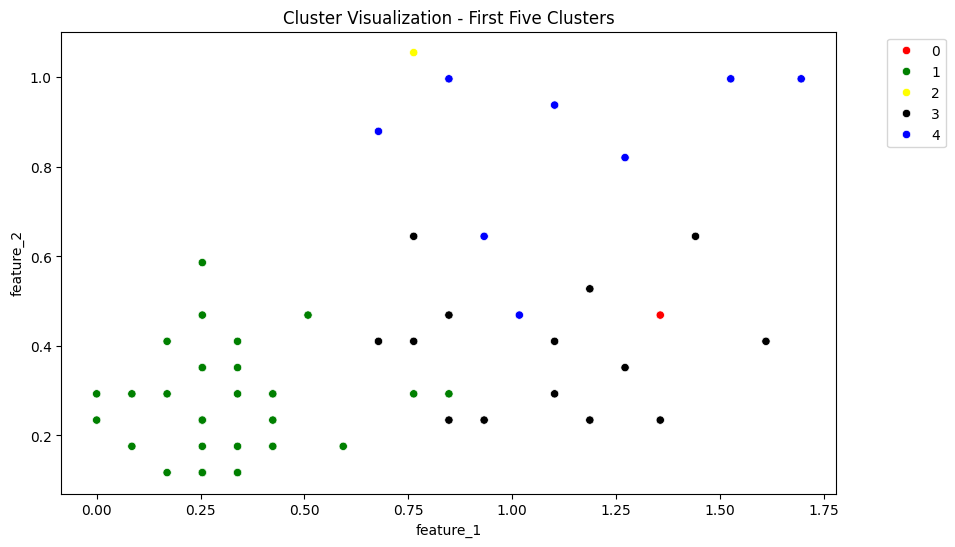

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

predictions = model.transform(vectorized_data)

# First five clusters

clusters = predictions.filter(col("cluster").between(0, 4))

clusters_pd = clusters.select("name", "cluster", "features").toPandas()

# Dimensions of Vectorized_data are used to do the plotting
# Here , I reduced the dimensions from 20 to 2
clusters_pd["feature_1"] = clusters_pd["features"].apply(lambda x: x[0] if len(x) > 0 else None)
clusters_pd["feature_2"] = clusters_pd["features"].apply(lambda x: x[1] if len(x) > 1 else None)

# Colors to use
custom_palette = {0: 'red', 1: 'green', 2: 'yellow', 3: 'black', 4: 'blue'}



plt.figure(figsize=(10, 6))

# Scatter plot
scatter_plot = sns.scatterplot(x="feature_1", y="feature_2", hue="cluster", data=clusters_pd, palette=custom_palette, legend="full")

scatter_plot.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.title("Cluster Visualization - First Five Clusters")
plt.show()
